In [1]:
import nflgame
import matplotlib.pyplot as plt

# returns the field position as the number of yards away from the opposing team's end zone
def field_pos_to_number(pos):
    pos = pos.split(" ")
    if pos[0] == "MIDFIELD":
        return 50
    elif pos[0] == "OWN":
        return 100-int(pos[1])
    elif pos[0] == "OPP":
        return int(pos[1])
    
# returns the current game clock as a quarter, clock tuple
def clock_to_nums(clock):
    clock = clock.split(" ")
    clock[0] = min(int(clock[0][1:]), 5)
    return clock[0], clock[1]

# returns the current play in a different format
def convert_play(p):
    quarter, time = clock_to_nums(p[2])
    return [quarter, time, p[3], p[4], field_pos_to_number(p[5]), p[-5], p[-4], p[-3], p[-2], p[-1]]
    
# get number of points scored on the conversion attempt after a touchdown
def get_conversion(plays, scores, i):
    # use list of scoring plays to figure out conversions
    if i < len(scores):
        #print(scores[i])
        if " TD " in scores[i]:
            if "failed" in scores[i]:
                return 0, i+1
            if "kick is good" in scores[i]:
                return 1, i+1
            if "run)" in scores[i] or "pass)" in scores[i]:
                return 2, i+1
            if i < len(scores)-1 and "defensive two point conversion" in scores[i+1]:
                return -1, i+2
    return 0, i+1

# get all plays for a given game in the proper format
def get_all_plays2(game, spread):   
    plays = nflgame.combine_plays([game])
    scores = game.scores
    score_index = 0
    home = 0
    away = 0
    win = (game.score_home >= game.score_away)
    plays2 = []
    for p in plays:
        plays2.append(p)

    all_plays = []
    for i in range(len(plays2)):
        p = plays2[i]
        if (p.down > 0 and str(p.time) != "None" and str(p.yardline) != "None"): # or p.note == "KICKOFF":
            # add play to all plays
            temp_play = [game.home, game.away, str(p.time), p.down, p.yards_togo, 
                         str(p.yardline), p.home, home, away, spread, win]
            all_plays.append(convert_play(temp_play))
#         if (not p.note == None) and len(p.note) >= 2 and (p.note[:2] == "2P" or p.note[:2] == "XP"):
#             print(p.note)
        # do scoring stuff
        if p.note == "TD":
            pts = 6
            is_home = p.home
            if p.punting_tot == 1:
                is_home = (not is_home)
            if p.defense_tds == 1:
                is_home = (not is_home)
#             is_home = True
#             if (not p.home and p.defense_tds != 1) or (p.home and p.defense_tds == 1):
#                 is_home = False
            conv, score_index = get_conversion(plays2, scores, score_index)
            # add conversion points if it wasn't a defensive 2 point conversion
            if conv != -1:
                pts += conv
            if is_home:
                home += pts
            else:
                away += pts
            # handle defensive 2 point conversion 
            if conv == -1:
                if is_home:
                    away += 2
                else:
                    home += 2
            #print(str(home) + "-" + str(away))

        elif p.note == "FG":
            if p.home:
                home += 3
            else:
                away += 3
            score_index += 1
                
        elif p.note == "SAF":
            if scores[score_index].split("-")[0][:-1] == str(game.home):
                home += 2
            else:
                away += 2
            score_index += 1

    return home, away, all_plays

def fix_name(t):
    if t == "SD":
        t = "LAC"
    if t == "LA" or t == "STL":
        t = "LAR"
    if t == "JAC":
        t = "JAX"
    return t
    
# get all plays from all weeks in weeks and all seasons in years. calls get_all_plays2
def get_plays(years, weeks, indexes=-1):
    all_plays = []
    for y in years:
        print(y)
        for w in weeks:
            #print(w)
            try:
                games = nflgame.games(y, week=w, kind='REG')
            except:
                continue
            current = data[(data["schedule_season"] == y) & (data["schedule_week"] == str(w))]
            if not indexes == -1:
                games = [games[i] for i in indexes]
            for g in games:
                t1 = g.home
                t2 = g.away
                t1 = fix_name(t1)
                t2 = fix_name(t2)
                #print(t2)
                spread = list(current.loc[(current["team1"] == t1) & (current["team2"] == t2)]["vegas_spread"])
                if len(spread) > 0:
                    h, a, cur_plays = get_all_plays2(g, spread[0])
                    if h != g.score_home or a != g.score_away:
                        #print("Actual: " + str(g.score_home) + "-" + str(g.score_away) + ", Mine: " + str(h) + "-" + 
                          #    str(a) + " " + str(g.home) + " " +str(g.away))
                        continue
                    all_plays += cur_plays
    return all_plays

# final model?
def collect_plays(all_plays):
    # collect plays and add interaction terms
    x_data = []
    y_data = []
    for p in all_plays:
        qtr = p[0]
        time = p[1].split(":")
        if len(time[0]) == 0:
            continue
        mins_left = 15*(4-min(qtr,4))+int(time[0])
        secs_left = int(time[1])
        time_left = round(mins_left + secs_left/60.,2)

        x_data.append([time_left]+p[2:-1])
        y_data.append(1 if p[-1] else 0)

    df = pd.DataFrame(x_data, columns=["time", "down", "distance", "fieldpos", "homeposs", "score_home", 
                                      "score_away", "spread"])

    
    df["last5"] = df["time"].apply(lambda x : 1 if x <= 5 else 0)
    
    # basic terms
    df["scorediff"] = (df["score_home"] - df["score_away"])
    df["down1"] = df["down"].apply(lambda x : 1 if x == 1 else 0)
    df["down2"] = df["down"].apply(lambda x : 1 if x == 2 else 0)
    df["down3"] = df["down"].apply(lambda x : 1 if x == 3 else 0)
    df["down4"] = df["down"].apply(lambda x : 1 if x == 4 else 0)
    df["homeposs"] = df["homeposs"].apply(lambda x : 1 if x else 0)
    
    # interaction terms
    df["down1*poss"] = df["down1"] * df["homeposs"] * (1-df["last5"])
    df["down2*poss"] = df["down2"] * df["homeposs"] * (1-df["last5"])
    df["down3*poss"] = df["down3"] * df["homeposs"] * (1-df["last5"])
    df["down4*poss"] = df["down4"] * df["homeposs"] * (1-df["last5"])
    df["distance*poss"] = df["distance"] * df["homeposs"] * (1-df["last5"])
    df["fieldpos*poss"] = df["fieldpos"] * df["homeposs"] * (1-df["last5"])
    
    # time dependent stuff
    # basic terms
    df["scorediff_time"] = (df["score_home"] - df["score_away"]) * df["last5"]
    df["down1_time"] = df["down"].apply(lambda x : 1 if x == 1 else 0) * df["last5"]
    df["down2_time"] = df["down"].apply(lambda x : 1 if x == 2 else 0) * df["last5"]
    df["down3_time"] = df["down"].apply(lambda x : 1 if x == 3 else 0) * df["last5"]
    df["down4_time"] = df["down"].apply(lambda x : 1 if x == 4 else 0) * df["last5"]
    
    # interaction terms
    df["down1*poss_time"] = df["down1"] * df["homeposs"] * df["last5"]
    df["down2*poss_time"] = df["down2"] * df["homeposs"] * df["last5"]
    df["down3*poss_time"] = df["down3"] * df["homeposs"] * df["last5"]
    df["down4*poss_time"] = df["down4"] * df["homeposs"] * df["last5"]
    df["distance*poss_time"] = df["distance"] * df["homeposs"] * df["last5"]
    df["fieldpos*poss_time"] = df["fieldpos"] * df["homeposs"] * df["last5"]
    
    # more interaction terms
    df["time*poss"] = (60-df["time"]) * df["homeposs"]
    df["time*spread"] = df["time"] * df["spread"]
    df["time*scorediff"] = (60-df["time"]) * df["scorediff"]
    df["fgrange"] = df["fieldpos"].apply(lambda x : 1 if x <= 35 else 0)
    df["fgrange*poss"] = df["fgrange"] * df["homeposs"]

    # additional terms
    df["close"] = df["scorediff"].apply(lambda x : 1 if abs(x) <= 8 else 0)
    df["last5min_close"] = df["last5"] * df["close"]
    df["last5min_close_poss"] = df["last5min_close"] * df["homeposs"]
    
    # fix basic terms
    df["scorediff"] *= (1-df["last5"])
    df["down1"] *= (1-df["last5"])
    df["down2"] *= (1-df["last5"])
    df["down3"] *= (1-df["last5"])
    df["down4"] *= (1-df["last5"])
    df["homeposs"] *= (1-df["last5"])
    
    # score correction
    df["sqrt_time"] = df["time"].apply(lambda x : 1 + np.sqrt(x))
    df["score_correction"] = df["scorediff"] / df["sqrt_time"]
    
    df.drop(["score_correction", "homeposs", "down", "score_home", "score_away", "last5", 
             "close", "sqrt_time", "last5min_close", "last5min_close_poss"], axis=1, inplace=True)
    
    return df, y_data

def remove_features(df):
    df.drop(["time*poss", "time*spread", "time*scorediff", "fgrange", "fgrange*poss"], axis=1, inplace=True)
    return df

def check_wp(x, y, model, threshold):
    y_pred = model.predict(x)
    
    results = []
    for i in range(len(y_pred)):
        if abs(y_pred[i]-threshold) <= 0.01:
            if y[i] == 1:
                results.append(1)
            else:
                results.append(0)
    #print(count)
    m = np.mean(results)
    return m, np.sqrt(m*(1-m)/len(results))

def check_wp2(x, y, model, threshold):
    y_pred = model.predict(x)
    time_left = list(x["time"])
    
    results = []
    for i in range(len(y_pred)):
        if time_left[i] > 5:
            continue
        if abs(y_pred[i]-threshold) <= 0.01:
            if y[i] == 1:
                results.append(1)
            else:
                results.append(0)
    #print(count)
    m = np.mean(results)
    return m, np.sqrt(m*(1-m)/len(results))

# check accuracy using original mse thing
def check_model_accuracy(test_x, test_y, model, last5):
    x = np.arange(0,1.01,0.05)
    y = []
    ses = []
    se = 0
    for i in x:
        if not last5:
            cur_mean, cur_se = check_wp(test_x, test_y, model, i)
        else:
            cur_mean, cur_se = check_wp2(test_x, test_y, model, i)
        y.append(cur_mean)
        ses.append(cur_se)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)) + ", SE = " + str(round(cur_se, 3)))
        se += (cur_mean-i)**2

    print("")
    print("mse: " + str(se/len(x)))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
# check accuracy using the brier score
def check_model_accuracy2(test_x, test_y, model):
    x = np.arange(0,1.01,0.05)
    y = []
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_se, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))
        se += cur_se
        count += cur_num

    print("")
    print("brier score: " + str(se/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
def get_brier(x, y, model, threshold):
    y_pred = model.predict(x)
    
    results = []
    errors = []
    
    y_pred = list(y_pred)
    for i in range(len(y_pred)):
        if abs(y_pred[i]-threshold) <= 0.025:
            if y[i] == 1:
                results.append(1)
            else:
                results.append(0)
            errors.append((y[i]-y_pred[i])**2)
    #print(count)
    return np.mean(results), sum(errors), len(errors)

# check accuracy using the brier score
def check_model_accuracy_all(test_x, test_y, model):
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
# check accuracy using the brier score
def check_model_accuracy_times(old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_test_x["time"] <= start_time) & (old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))# + ", brier: " + str(round(cur_brier/cur_num, 3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
# check accuracy using the brier score
def check_model_accuracy_times_pca(old_old_test_x, old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_old_test_x["time"] <= start_time) & 
                               (old_old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))# + ", brier: " + str(round(cur_brier/cur_num, 3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()

# check accuracy using the brier score and does the binary prediction thing
def check_model_accuracy_times2(old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_test_x["time"] <= start_time) & (old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))# + ", brier: " + str(round(cur_brier/cur_num, 3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num
        
    # do binary thing
    y_pred = model.predict(test_x)
    b_y_pred = [1 if val > 0.5 else 0 for val in y_pred]
    correct = 0
    for i in range(len(b_y_pred)):
        if b_y_pred[i] == test_y[i]:
            correct += 1

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))
    print("binary prediction accuracy: " + str(correct/len(b_y_pred)))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    fig = plt.gcf()
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    return fig

In [2]:
import pandas as pd
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# get spread data
data = pd.read_csv("elo_and_vegas_spreads2.csv")

data = data.drop(data.columns[0], axis=1)
data = data[data["schedule_season"] >= 2009]
data = data[data["schedule_playoff"] == False]
data.drop(["schedule_playoff"],axis=1,inplace=True)

# get training and testing data
train_fraction = 0.7

years = [i for i in range(2009,2019)]
weeks = [i for i in range(1,18)]
plays = get_plays(years,weeks)

x_data, y_data = collect_plays(plays)

# convert to lists, randomize
cols = list(x_data)
x_data = x_data.values.tolist()
alldata = list(zip(x_data, y_data))
random.shuffle(alldata)
x_data, y_data = zip(*alldata)
x_data = list(x_data)
y_data = list(y_data)

# simpler model
x_data2 = pd.DataFrame(data=np.array(x_data), columns=cols)
x_data2 = remove_features(x_data2)
cols2 = list(x_data2)
x_data2 = x_data2.values.tolist()

# take the appropriate training and testing sets
num_points = int(train_fraction*len(x_data))
train_x = pd.DataFrame(x_data[:num_points], columns=cols)
train_y = y_data[:num_points]
test_x = pd.DataFrame(x_data[num_points:], columns=cols)
test_y = y_data[num_points:]

# training and testing for simpler model
train_x2 = pd.DataFrame(x_data2[:num_points], columns=cols2)
test_x2 = pd.DataFrame(x_data2[num_points:], columns=cols2)

/Users/Bill/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


A Jupyter Widget

full knn full game, n_neighbors 20
0.0: 0.009
0.05: 0.035
0.1: 0.087
0.15: 0.115
0.2: 0.169
0.25: 0.214
0.3: 0.269
0.35: 0.312
0.4: 0.368
0.45: 0.423
0.5: 0.49
0.55: 0.554
0.6: 0.614
0.65: 0.674
0.7: 0.727
0.75: 0.787
0.8: 0.835
0.85: 0.872
0.9: 0.919
0.95: 0.948
1.0: 0.992

mse: 0.0006266525183968117
brier score: 0.12151642391030482


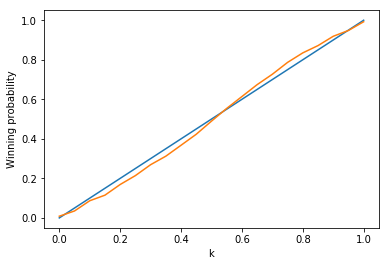

full knn full game, n_neighbors 30
0.0: 0.007
0.05: 0.034
0.1: 0.069
0.15: 0.119
0.2: 0.167
0.25: 0.217
0.3: 0.253
0.35: 0.313
0.4: 0.371
0.45: 0.431
0.5: 0.499
0.55: 0.55
0.6: 0.616
0.65: 0.654
0.7: 0.723
0.75: 0.784
0.8: 0.832
0.85: 0.881
0.9: 0.924
0.95: 0.958
1.0: 0.994

mse: 0.0006606292312412502
brier score: 0.1250743492737213


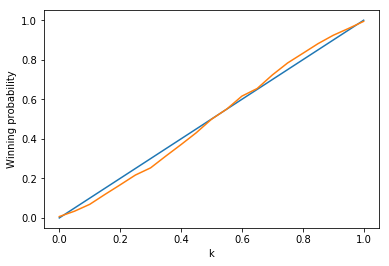

full knn full game, n_neighbors 40
0.0: 0.007
0.05: 0.027
0.1: 0.075
0.15: 0.11
0.2: 0.168
0.25: 0.211
0.3: 0.269
0.35: 0.31
0.4: 0.376
0.45: 0.432
0.5: 0.509
0.55: 0.552
0.6: 0.603
0.65: 0.657
0.7: 0.716
0.75: 0.774
0.8: 0.836
0.85: 0.88
0.9: 0.929
0.95: 0.962
1.0: 0.994

mse: 0.0006172350840816533
brier score: 0.1276937484553618


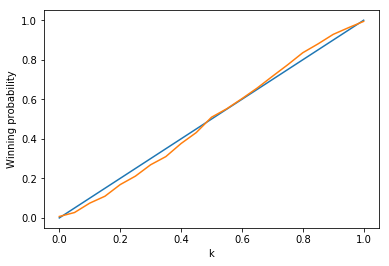

full knn full game, n_neighbors 50
0.0: 0.008
0.05: 0.024
0.1: 0.066
0.15: 0.112
0.2: 0.165
0.25: 0.219
0.3: 0.264
0.35: 0.32
0.4: 0.371
0.45: 0.447
0.5: 0.501
0.55: 0.563
0.6: 0.6
0.65: 0.65
0.7: 0.707
0.75: 0.779
0.8: 0.835
0.85: 0.878
0.9: 0.928
0.95: 0.968
1.0: 0.994

mse: 0.0006087956926201071
brier score: 0.12976631917057313


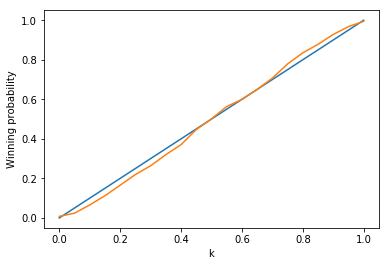

full knn full game, n_neighbors 60
0.0: 0.007
0.05: 0.025
0.1: 0.063
0.15: 0.116
0.2: 0.162
0.25: 0.218
0.3: 0.261
0.35: 0.322
0.4: 0.386
0.45: 0.444
0.5: 0.504
0.55: 0.562
0.6: 0.604
0.65: 0.649
0.7: 0.704
0.75: 0.772
0.8: 0.835
0.85: 0.88
0.9: 0.926
0.95: 0.968
1.0: 0.995

mse: 0.000577125886435028
brier score: 0.13137729296868964


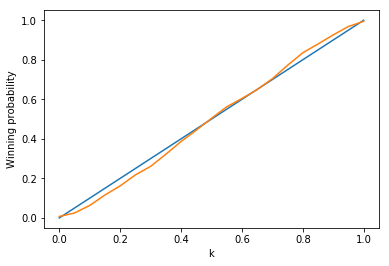

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tnrange

neighbors = [20, 30, 40, 50, 60]

for i in tnrange(len(neighbors)):
    knn = KNeighborsRegressor(n_neighbors=neighbors[i], weights="distance") 
    knn.fit(train_x, train_y)

    print("full knn full game, n_neighbors " + str(neighbors[i]))
    check_model_accuracy_times(test_x, test_y, knn, 60, 0)

full knn full game
0.0: 0.018
0.05: 0.056
0.1: 0.119
0.15: 0.137
0.2: 0.192
0.25: 0.222
0.3: 0.27
0.35: 0.317
0.4: 0.394
0.45: 0.431
0.5: 0.495
0.55: 0.56
0.6: 0.62
0.65: 0.676
0.7: 0.723
0.75: 0.786
0.8: 0.815
0.85: 0.861
0.9: 0.881
0.95: 0.947
1.0: 0.982

mse: 0.0003929661519215962
brier score: 0.11655568876675926


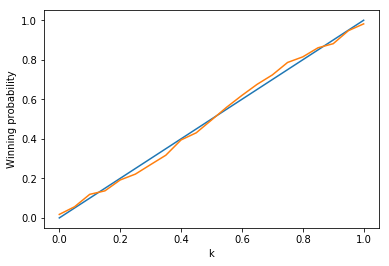

In [5]:
# 10 neighbors
print("full knn full game")
check_model_accuracy_times(test_x, test_y, knn, 60, 0)

A Jupyter Widget

full knn full game, n_neighbors 5
0.0: 0.046
0.05: 0.057
0.1: 0.067
0.15: 0.168
0.2: 0.261
0.25: 0.285
0.3: 0.286
0.35: 0.327
0.4: 0.443
0.45: 0.499
0.5: 0.517
0.55: 0.532
0.6: 0.604
0.65: 0.688
0.7: 0.738
0.75: 0.727
0.8: 0.764
0.85: 0.829
0.9: 0.939
0.95: 0.912
1.0: 0.958

mse: 0.001141063939430503
brier score: 0.11528425254613689


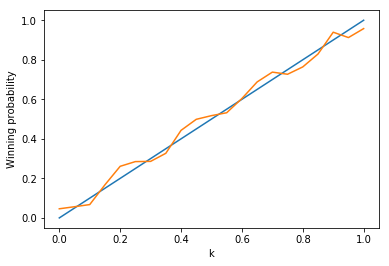

full knn full game, n_neighbors 15
0.0: 0.011
0.05: 0.052
0.1: 0.087
0.15: 0.138
0.2: 0.171
0.25: 0.218
0.3: 0.256
0.35: 0.334
0.4: 0.364
0.45: 0.433
0.5: 0.483
0.55: 0.558
0.6: 0.617
0.65: 0.672
0.7: 0.733
0.75: 0.788
0.8: 0.828
0.85: 0.859
0.9: 0.907
0.95: 0.942
1.0: 0.989

mse: 0.0005149528473417995
brier score: 0.11919473683600929


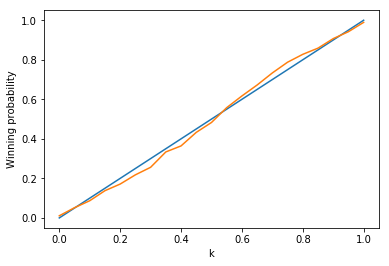

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tnrange

neighbors = [5, 15]

for i in tnrange(len(neighbors)):
    knn = KNeighborsRegressor(n_neighbors=neighbors[i], weights="distance") 
    knn.fit(train_x, train_y)

    print("full knn full game, n_neighbors " + str(neighbors[i]))
    check_model_accuracy_times(test_x, test_y, knn, 60, 0)

A Jupyter Widget

full knn full game, n_neighbors 5
0.0: 0.076
0.05: 0.302
0.1: 0.232
0.15: 0.183
0.2: 0.288
0.25: 0.383
0.3: 0.353
0.35: 0.353
0.4: 0.451
0.45: 0.52
0.5: 0.498
0.55: 0.532
0.6: 0.586
0.65: 0.673
0.7: 0.688
0.75: 0.649
0.8: 0.749
0.85: 0.829
0.9: 0.814
0.95: 0.718
1.0: 0.93

mse: 0.00971148597934516
brier score: 0.1521073463850627


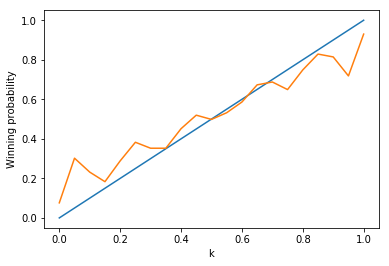

full knn full game, n_neighbors 10
0.0: 0.034
0.05: 0.117
0.1: 0.138
0.15: 0.174
0.2: 0.23
0.25: 0.269
0.3: 0.325
0.35: 0.375
0.4: 0.426
0.45: 0.46
0.5: 0.517
0.55: 0.547
0.6: 0.597
0.65: 0.64
0.7: 0.691
0.75: 0.736
0.8: 0.781
0.85: 0.825
0.9: 0.872
0.95: 0.899
1.0: 0.964

mse: 0.0008269761996375225
brier score: 0.14724391415918064


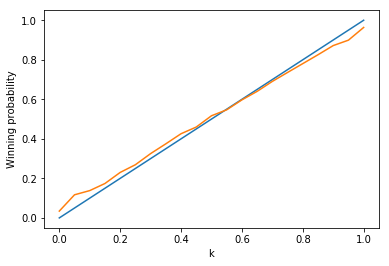

full knn full game, n_neighbors 15
0.0: 0.021
0.05: 0.077
0.1: 0.131
0.15: 0.166
0.2: 0.206
0.25: 0.264
0.3: 0.287
0.35: 0.366
0.4: 0.42
0.45: 0.457
0.5: 0.515
0.55: 0.556
0.6: 0.589
0.65: 0.648
0.7: 0.695
0.75: 0.746
0.8: 0.788
0.85: 0.835
0.9: 0.878
0.95: 0.924
1.0: 0.976

mse: 0.0002875011430438327
brier score: 0.14604925992896325


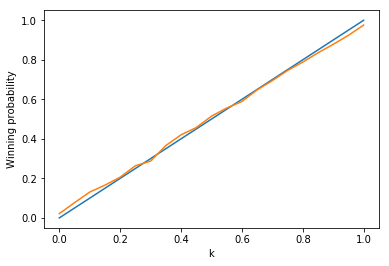

full knn full game, n_neighbors 20
0.0: 0.016
0.05: 0.059
0.1: 0.102
0.15: 0.148
0.2: 0.211
0.25: 0.24
0.3: 0.294
0.35: 0.366
0.4: 0.412
0.45: 0.448
0.5: 0.5
0.55: 0.551
0.6: 0.602
0.65: 0.648
0.7: 0.692
0.75: 0.75
0.8: 0.802
0.85: 0.849
0.9: 0.894
0.95: 0.938
1.0: 0.983

mse: 7.436341743830879e-05
brier score: 0.14572376109267277


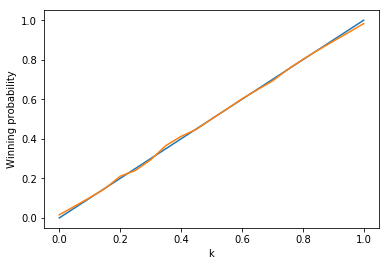

In [11]:
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tnrange

neighbors = [5, 10, 15, 20]

for i in tnrange(len(neighbors)):
    knn = KNeighborsRegressor(n_neighbors=neighbors[i], weights="distance") 
    knn.fit(train_x2, train_y)

    print("full knn full game, n_neighbors " + str(neighbors[i]))
    check_model_accuracy_times(test_x2, test_y, knn, 60, 0)

full knn full game, n_neighbors 20
0.0: 0.009
0.05: 0.035
0.1: 0.087
0.15: 0.115
0.2: 0.169
0.25: 0.214
0.3: 0.269
0.35: 0.312
0.4: 0.368
0.45: 0.423
0.5: 0.49
0.55: 0.554
0.6: 0.614
0.65: 0.674
0.7: 0.727
0.75: 0.787
0.8: 0.835
0.85: 0.872
0.9: 0.919
0.95: 0.948
1.0: 0.992

mse: 0.0006266525183968117
brier score: 0.12151642391030482


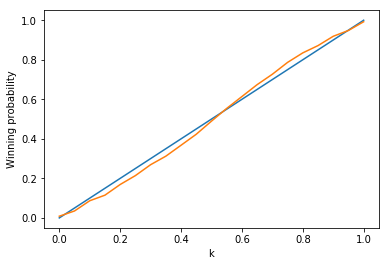

full knn last 5, n_neighbors 20
0.0: 0.002
0.05: 0.046
0.1: 0.107
0.15: 0.134
0.2: 0.188
0.25: 0.241
0.3: 0.311
0.35: 0.287
0.4: 0.335
0.45: 0.458
0.5: 0.522
0.55: 0.572
0.6: 0.604
0.65: 0.669
0.7: 0.709
0.75: 0.784
0.8: 0.843
0.85: 0.881
0.9: 0.938
0.95: 0.96
1.0: 0.998

mse: 0.0007550677287225573
brier score: 0.06883284174874954


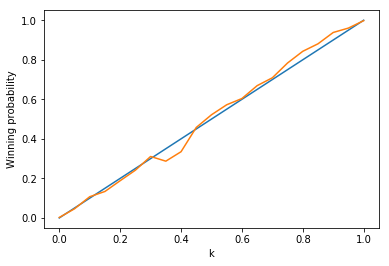

simplified knn full game, n_neighbors 20
0.0: 0.016
0.05: 0.059
0.1: 0.102
0.15: 0.148
0.2: 0.211
0.25: 0.24
0.3: 0.294
0.35: 0.366
0.4: 0.412
0.45: 0.448
0.5: 0.5
0.55: 0.551
0.6: 0.602
0.65: 0.648
0.7: 0.692
0.75: 0.75
0.8: 0.802
0.85: 0.849
0.9: 0.894
0.95: 0.938
1.0: 0.983

mse: 7.436341743830879e-05
brier score: 0.14572376109267277


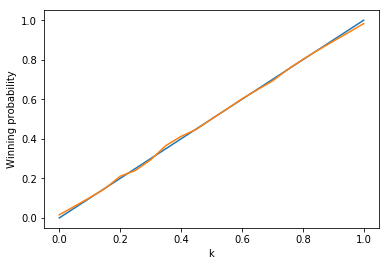

simplified knn last 5, n_neighbors 20
0.0: 0.005
0.05: 0.039
0.1: 0.074
0.15: 0.115
0.2: 0.148
0.25: 0.234
0.3: 0.257
0.35: 0.322
0.4: 0.342
0.45: 0.445
0.5: 0.505
0.55: 0.527
0.6: 0.642
0.65: 0.72
0.7: 0.65
0.75: 0.815
0.8: 0.846
0.85: 0.87
0.9: 0.936
0.95: 0.97
1.0: 0.994

mse: 0.001395816278460288
brier score: 0.0791414231822332


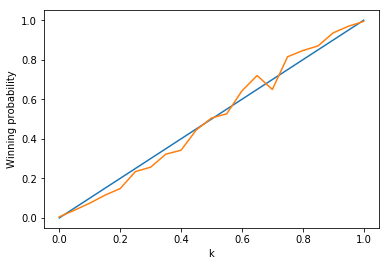

In [12]:
n = 20

# full model
knn = KNeighborsRegressor(n_neighbors=n, weights="distance") 
knn.fit(train_x, train_y)

print("full knn full game, n_neighbors " + str(n))
fig = check_model_accuracy_times(test_x, test_y, knn, 60, 0)
fig.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/knn/randomsplits/full_60.png")

print("full knn last 5, n_neighbors " + str(n))
fig = check_model_accuracy_times(test_x, test_y, knn, 5, 0)
fig.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/knn/randomsplits/full_5.png")

# simplified model
knn2 = KNeighborsRegressor(n_neighbors=n, weights="distance") 
knn2.fit(train_x2, train_y)

print("simplified knn full game, n_neighbors " + str(n))
fig = check_model_accuracy_times(test_x2, test_y, knn2, 60, 0)
fig.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/knn/randomsplits/simplified_60.png")

print("simplified knn last 5, n_neighbors " + str(n))
fig = check_model_accuracy_times(test_x2, test_y, knn2, 5, 0)
fig.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/knn/randomsplits/simplified_5.png")

## pelechrinis

full knn full game, n_neighbors 20
0.0: 0.007
0.05: 0.043
0.1: 0.079
0.15: 0.109
0.2: 0.152
0.25: 0.208
0.3: 0.272
0.35: 0.332
0.4: 0.371
0.45: 0.436
0.5: 0.495
0.55: 0.56
0.6: 0.6
0.65: 0.663
0.7: 0.722
0.75: 0.794
0.8: 0.829
0.85: 0.87
0.9: 0.92
0.95: 0.952
1.0: 0.993

mse: 0.0006151589795742333
brier score: 0.12171953170217302
binary prediction accuracy: 0.8222145347135368


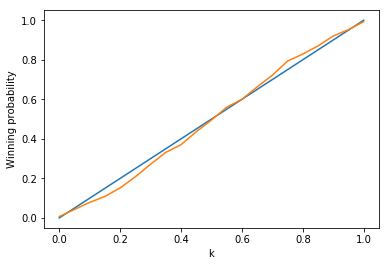

full knn last 5, n_neighbors 20
0.0: 0.002
0.05: 0.047
0.1: 0.083
0.15: 0.079
0.2: 0.175
0.25: 0.207
0.3: 0.238
0.35: 0.333
0.4: 0.362
0.45: 0.467
0.5: 0.535
0.55: 0.53
0.6: 0.592
0.65: 0.659
0.7: 0.677
0.75: 0.809
0.8: 0.857
0.85: 0.878
0.9: 0.925
0.95: 0.969
1.0: 0.999

mse: 0.001168638960746799
brier score: 0.06789276683687637
binary prediction accuracy: 0.9016537508987776


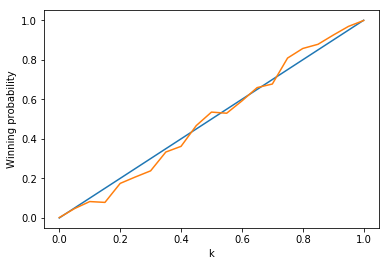

simplified knn full game, n_neighbors 20
0.0: 0.014
0.05: 0.057
0.1: 0.105
0.15: 0.149
0.2: 0.189
0.25: 0.264
0.3: 0.307
0.35: 0.351
0.4: 0.411
0.45: 0.462
0.5: 0.496
0.55: 0.555
0.6: 0.603
0.65: 0.647
0.7: 0.697
0.75: 0.741
0.8: 0.794
0.85: 0.85
0.9: 0.885
0.95: 0.937
1.0: 0.982

mse: 8.48194670210612e-05
brier score: 0.14692430872340842
binary prediction accuracy: 0.7809947044892094


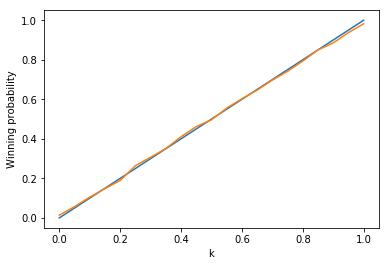

simplified knn last 5, n_neighbors 20
0.0: 0.003
0.05: 0.053
0.1: 0.057
0.15: 0.099
0.2: 0.148
0.25: 0.239
0.3: 0.23
0.35: 0.347
0.4: 0.352
0.45: 0.402
0.5: 0.464
0.55: 0.565
0.6: 0.612
0.65: 0.68
0.7: 0.715
0.75: 0.77
0.8: 0.819
0.85: 0.911
0.9: 0.927
0.95: 0.958
1.0: 0.995

mse: 0.0011845653591622536
brier score: 0.08046438230750402
binary prediction accuracy: 0.8867140688663417


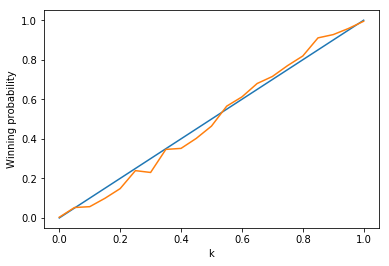

In [3]:
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tnrange

n = 20

# full model
knn = KNeighborsRegressor(n_neighbors=n, weights="distance") 
knn.fit(train_x, train_y)

# simplified model
knn2 = KNeighborsRegressor(n_neighbors=n, weights="distance") 
knn2.fit(train_x2, train_y)

print("full knn full game, n_neighbors " + str(n))
fig = check_model_accuracy_times2(test_x, test_y, knn, 60, 0)
fig.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/knn/randomsplits/full_60.png")

print("full knn last 5, n_neighbors " + str(n))
fig = check_model_accuracy_times2(test_x, test_y, knn, 5, 0)
fig.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/knn/randomsplits/full_5.png")

# simplified model
knn2 = KNeighborsRegressor(n_neighbors=n, weights="distance") 
knn2.fit(train_x2, train_y)

print("simplified knn full game, n_neighbors " + str(n))
fig = check_model_accuracy_times2(test_x2, test_y, knn2, 60, 0)
fig.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/knn/randomsplits/simplified_60.png")

print("simplified knn last 5, n_neighbors " + str(n))
fig = check_model_accuracy_times2(test_x2, test_y, knn2, 5, 0)
fig.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/knn/randomsplits/simplified_5.png")

simplified knn full game
0.0: 0.016
0.05: 0.059
0.1: 0.102
0.15: 0.148
0.2: 0.211
0.25: 0.24
0.3: 0.294
0.35: 0.366
0.4: 0.412
0.45: 0.448
0.5: 0.5
0.55: 0.551
0.6: 0.602
0.65: 0.648
0.7: 0.692
0.75: 0.75
0.8: 0.802
0.85: 0.849
0.9: 0.894
0.95: 0.938
1.0: 0.983

mse: 7.436341743830879e-05
brier score: 0.14572376109267277
binary prediction accuracy: 0.7830614616319398


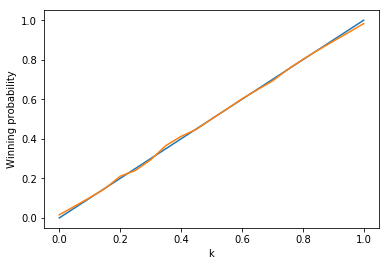

simplified knn last 5
0.0: 0.005
0.05: 0.039
0.1: 0.074
0.15: 0.115
0.2: 0.148
0.25: 0.234
0.3: 0.257
0.35: 0.322
0.4: 0.342
0.45: 0.445
0.5: 0.505
0.55: 0.527
0.6: 0.642
0.65: 0.72
0.7: 0.65
0.75: 0.815
0.8: 0.846
0.85: 0.87
0.9: 0.936
0.95: 0.97
1.0: 0.994

mse: 0.001395816278460288
brier score: 0.0791414231822332
binary prediction accuracy: 0.8880725340003126


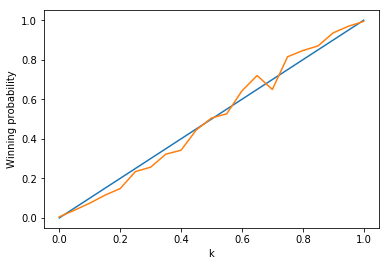

full knn full game
0.0: 0.009
0.05: 0.035
0.1: 0.087
0.15: 0.115
0.2: 0.169
0.25: 0.214
0.3: 0.269
0.35: 0.312
0.4: 0.368
0.45: 0.423
0.5: 0.49
0.55: 0.554
0.6: 0.614
0.65: 0.674
0.7: 0.727
0.75: 0.787
0.8: 0.835
0.85: 0.872
0.9: 0.919
0.95: 0.948
1.0: 0.992

mse: 0.0006266525183968117
brier score: 0.12151642391030482
binary prediction accuracy: 0.8241216282143395


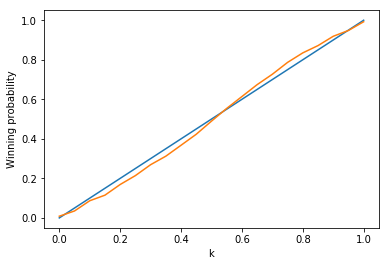

full knn last 5
0.0: 0.002
0.05: 0.046
0.1: 0.107
0.15: 0.134
0.2: 0.188
0.25: 0.241
0.3: 0.311
0.35: 0.287
0.4: 0.335
0.45: 0.458
0.5: 0.522
0.55: 0.572
0.6: 0.604
0.65: 0.669
0.7: 0.709
0.75: 0.784
0.8: 0.843
0.85: 0.881
0.9: 0.938
0.95: 0.96
1.0: 0.998

mse: 0.0007550677287225573
brier score: 0.06883284174874954
binary prediction accuracy: 0.9012818508675942


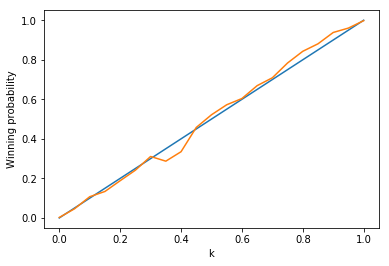

In [13]:
# with bins
print("simplified knn full game")
check_model_accuracy_times2(test_x2, test_y, knn2, 60, 0)

print("simplified knn last 5")
check_model_accuracy_times2(test_x2, test_y, knn2, 5, 0)

print("full knn full game")
check_model_accuracy_times2(test_x, test_y, knn, 60, 0)

print("full knn last 5")
check_model_accuracy_times2(test_x, test_y, knn, 5, 0)

## lock and nettleton

In [14]:
import pandas as pd
import random
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# get spread data
data = pd.read_csv("elo_and_vegas_spreads2.csv")

data = data.drop(data.columns[0], axis=1)
data = data[data["schedule_season"] >= 2009]
data = data[data["schedule_playoff"] == False]
data.drop(["schedule_playoff"],axis=1,inplace=True)

# get training and testing data
test_fraction = 0.3

years = [i for i in range(2009,2019)]
weeks = [i for i in range(1,18)]
plays = []
for y in years:
    plays.append(get_plays([y],weeks))

2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


In [15]:
x_data = []
y_data = []
for i in range(len(plays)):
    x_data_cur, y_data_cur = collect_plays(plays[i])
    x_data.append(x_data_cur)
    y_data.append(y_data_cur)
    
train_x = []
test_x = []
train_y = []
test_y = []

for i in range(len(x_data)):
    cur_x = pd.concat([x_data[j] for j in range(len(x_data)) if j != i])
    cur_y = [y_data[j] for j in range(len(y_data)) if j != i]
    cur_y = [val for ylist in cur_y for val in ylist]
    train_x.append(cur_x)
    train_y.append(cur_y)
    test_x.append(x_data[i])
    test_y.append(y_data[i])

cols = list(train_x[0])
train_x2 = []
test_x2 = []
for i in range(len(train_x)):
    temp = pd.DataFrame(data=np.array(train_x[i]), columns=cols)
    train_x2.append(remove_features(temp))
    temp2 = pd.DataFrame(data=np.array(test_x[i]), columns=cols)
    test_x2.append(remove_features(temp2))


In [21]:
import math

# check accuracy using the brier score
def check_model_accuracy_times3(old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_test_x["time"] <= start_time) & (old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    counts = []
    means = []
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean * cur_num)
        brier += cur_brier
        counts.append(cur_num)

    return y, brier, counts

def check_accuracy_lock_nettleton(x, y, model, start, end):
    cur_means, cur_brier, cur_count = check_model_accuracy_times3(x, y, model, start, end)
    
    return cur_means, cur_brier, cur_count, list(np.divide(np.array(cur_means), np.array(cur_count))), \
        cur_brier / sum(cur_count)

def check_accuracy_lock_nettleton_wrapper(test_x, test_y, results, start, end):
    means1 = []
    briers1 = []
    counts1 = [0 for i in range(21)]
    cv_means1 = []
    cv_briers1 = []

    for i in range(len(test_x)):
        cur1, cur2, cur3, cur4, cur5 = check_accuracy_lock_nettleton(test_x[i], test_y[i], results[i], start, end)
        means1.append(cur1)
        briers1.append(cur2)
        counts1 = list(np.array(counts1) + np.array(cur3))
        cv_means1.append(cur4)
        cv_briers1.append(cur5)

    # model 1
    x = np.arange(0, 1.01, 0.05)

    ses1 = [0 for i in range(len(cv_means1))]
    count1 = 0
    for i in range(len(cv_means1)):
        for j in range(len(cv_means1[i])):
            if math.isnan(cv_means1[i][j]):
                continue
            ses1[i] += (cv_means1[i][j]-x[j])**2
            count1 += 1
        ses1[i] = ses1[i] / count1
        count1 = 0

    print("average mse: " + str(sum(ses1)/(len(cv_means1))))
    print("average brier score: " + str(sum(cv_briers1)/len(cv_briers1)))
    print("")
    
def check_accuracy_lock_nettleton_wrapper2(test_x, test_y, results, start, end, filename_start):
    means1 = []
    briers1 = []
    counts1 = [0 for i in range(21)]
    cv_means1 = []
    cv_briers1 = []

    for i in range(len(test_x)):
        cur1, cur2, cur3, cur4, cur5 = check_accuracy_lock_nettleton(test_x[i], test_y[i], results[i], start, end)
        means1.append(cur1)
        briers1.append(cur2)
        counts1 = list(np.array(counts1) + np.array(cur3))
        cv_means1.append(cur4)
        cv_briers1.append(cur5)

    # model 1
    x = np.arange(0, 1.01, 0.05)

    ses1 = [0 for i in range(len(cv_means1))]
    count1 = 0
    for i in range(len(cv_means1)):
        for j in range(len(cv_means1[i])):
            if math.isnan(cv_means1[i][j]):
                continue
            ses1[i] += (cv_means1[i][j]-x[j])**2
            count1 += 1
        ses1[i] = ses1[i] / count1
        count1 = 0

    print("average mse: " + str(sum(ses1)/(len(cv_means1))))
    print("average brier score: " + str(sum(cv_briers1)/len(cv_briers1)))
    print("")
    
    for i in range(len(cv_means1)):
        print(years[i])
        print("mse: " + str(sum([(cv_means1[i][j]-x[j])**2 for j in range(len(x))]) / len(x)))
        print("brier: " + str(cv_briers1[i]))
        plt.close()
        plt.plot(x,x) # for reference
        plt.plot(x,cv_means1[i])
        plt.xlabel("k")
        plt.ylabel("Winning probability")
        plt.title("omitted season: " + str(years[i]))
        plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/diagrams/knn/byseason/"+filename_start+
                    str(years[i])+"_last5.png")
        plt.show()

In [18]:
means1 = []
briers1 = []
means2 = []
briers2 = []
counts1 = [0 for i in range(21)]
counts2 = [0 for i in range(21)]
cv_means1 = []
cv_means2 = []
cv_briers1 = []
cv_briers2 = []

results1 = []
results2 = []

n = 20

for i in tnrange(len(train_x)):
    print(i)
    knn = KNeighborsRegressor(n_neighbors=n, weights="distance") 
    knn.fit(train_x[i], train_y[i])
    results1.append(knn)
    
    knn = KNeighborsRegressor(n_neighbors=n, weights="distance") 
    knn.fit(train_x2[i], train_y[i])
    results2.append(knn)

A Jupyter Widget

0
1
2
3
4
5
6
7
8
9



In [19]:
# full model
print("full model \n")
print("full game")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 60, 0)
print("1st quarter")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 60, 45)
print("2nd quarter")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 45, 30)
print("3rd quarter")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 30, 15)
print("4th quarter")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 15, 0)

# simplified model
print("simplified model \n")
print("full game")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 60, 0)
print("1st quarter")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 60, 45)
print("2nd quarter")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 45, 30)
print("3rd quarter")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 30, 15)
print("4th quarter")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 15, 0)

full model 

full game
average mse: 0.007511006456603855
average brier score: 0.17324141933933754

1st quarter
average mse: 0.016874070102616136
average brier score: 0.2291650760366437

2nd quarter
average mse: 0.009492858835841759
average brier score: 0.19795872803531084

3rd quarter
average mse: 0.007461890600303539
average brier score: 0.1598369753829066

4th quarter
average mse: 0.0052621955431920876
average brier score: 0.11386243286105957

simplified model 

full game
average mse: 0.0025566843931735255
average brier score: 0.16329465190634967

1st quarter
average mse: 0.011288278266040355
average brier score: 0.21816054840758664

2nd quarter
average mse: 0.0036539940228453903
average brier score: 0.18491295948363792

3rd quarter
average mse: 0.003212763352051738
average brier score: 0.14868685926371014

4th quarter
average mse: 0.002480067468959921
average brier score: 0.10892988652090785



full model

average mse: 0.007511006456603855
average brier score: 0.17324141933933754

2009
mse: 0.0065519589737353485
brier: 0.1639373361187262


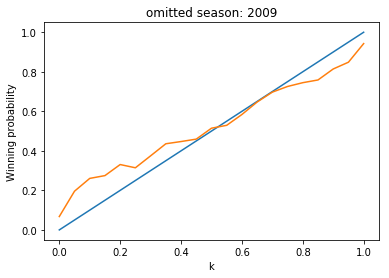

2010
mse: 0.005532224629286103
brier: 0.17322909608065637


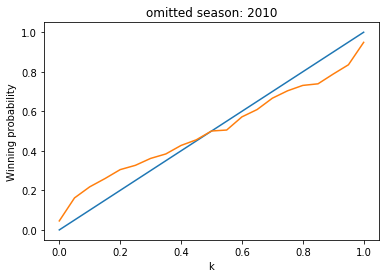

2011
mse: 0.009416277963295446
brier: 0.17859591101099623


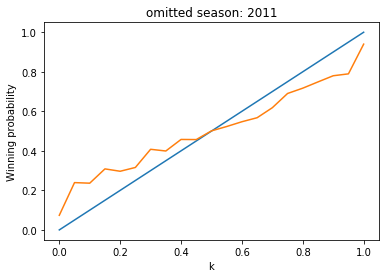

2012
mse: 0.00849079500857921
brier: 0.1739476777893526


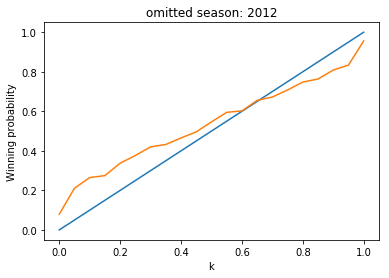

2013
mse: 0.011910198669564174
brier: 0.1818249937916974


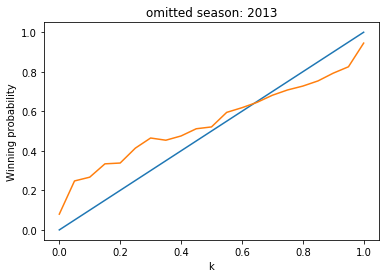

2014
mse: 0.006596856084782034
brier: 0.16823736559330776


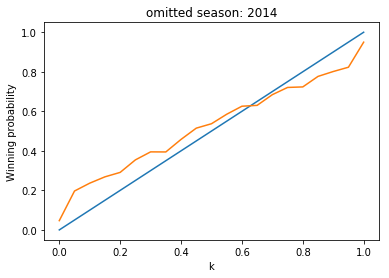

2015
mse: 0.007776306551854701
brier: 0.18569215037646136


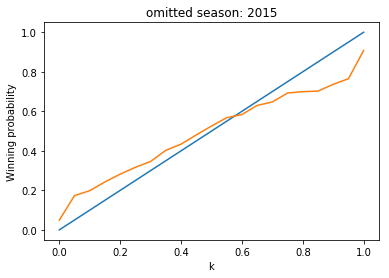

2016
mse: 0.006245504724209329
brier: 0.18092786085908147


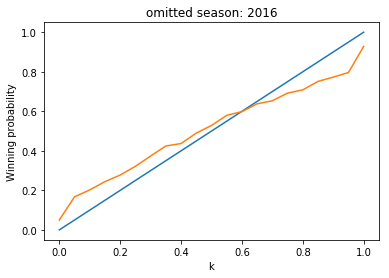

2017
mse: 0.0022941894898012424
brier: 0.1578836944603882


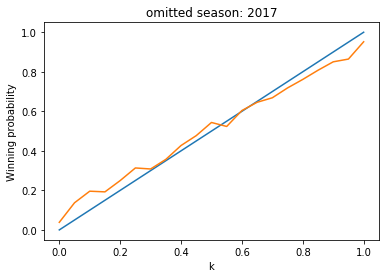

2018
mse: 0.010295752470930966
brier: 0.1681381073127079


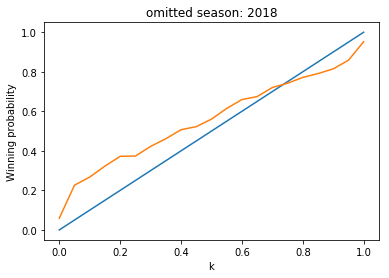

simplified model

average mse: 0.0025566843931735255
average brier score: 0.16329465190634967

2009
mse: 0.0027139533940287175
brier: 0.15476900256814027


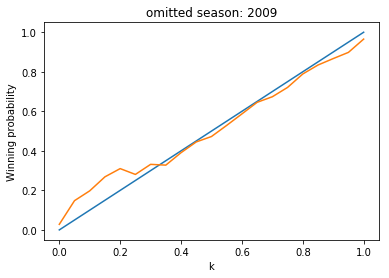

2010
mse: 0.0016016970541988325
brier: 0.16381807292168984


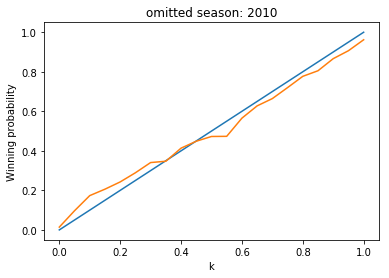

2011
mse: 0.003856863970253254
brier: 0.1708462470649192


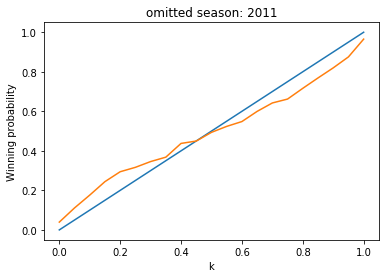

2012
mse: 0.00343041597820046
brier: 0.16514558450081504


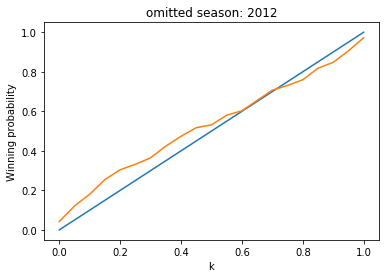

2013
mse: 0.004234766401178935
brier: 0.17097475082580932


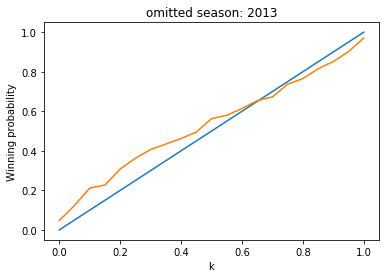

2014
mse: 0.0014316886357318569
brier: 0.1581887200040602


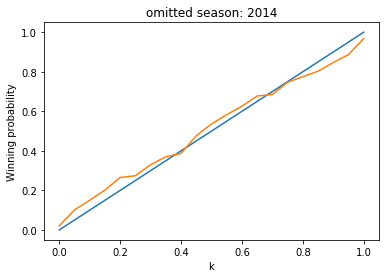

2015
mse: 0.0030381760052917593
brier: 0.17426345329240783


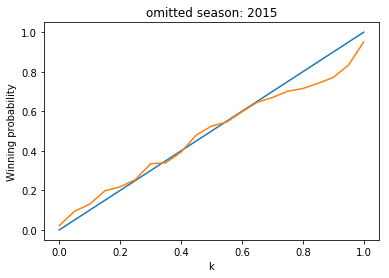

2016
mse: 0.001428510030752336
brier: 0.16933575979794238


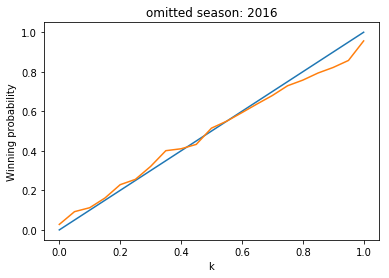

2017
mse: 0.0002763299673481128
brier: 0.14688542393860324


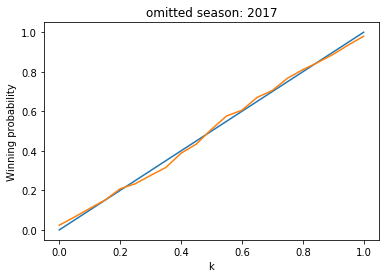

2018
mse: 0.003554442494750989
brier: 0.15871950414910954


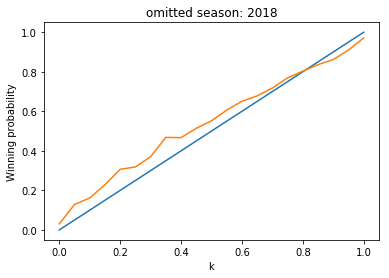

In [20]:
print("full model\n")
check_accuracy_lock_nettleton_wrapper2(test_x, test_y, results1, 60, 0, "full")

print("simplified model\n")
check_accuracy_lock_nettleton_wrapper2(test_x2, test_y, results2, 60, 0, "simplified")

full model

average mse: 0.006549499266468821
average brier score: 0.0937350798802419

2009
mse: 0.009711865665555888
brier: 0.09453930978856703


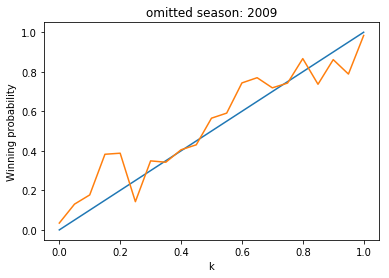

2010
mse: 0.004319436041815545
brier: 0.09334117073222183


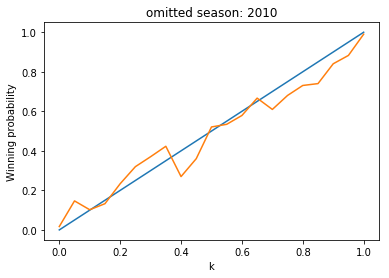

2011
mse: 0.006708397164913489
brier: 0.09334821507161598


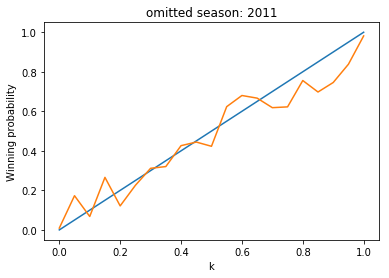

2012
mse: 0.00937026160137256
brier: 0.09518514911048971


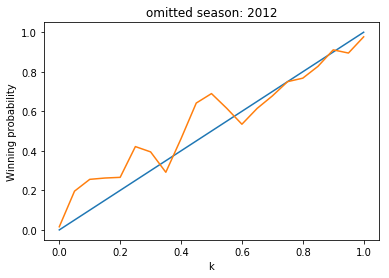

2013
mse: 0.007553178435821423
brier: 0.09725697094932041


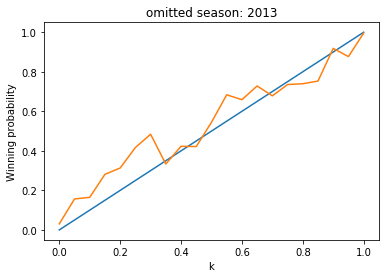

2014
mse: 0.004567940855402642
brier: 0.07631960685274868


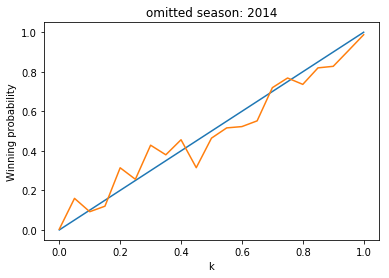

2015
mse: 0.004637953612333916
brier: 0.10513729131150241


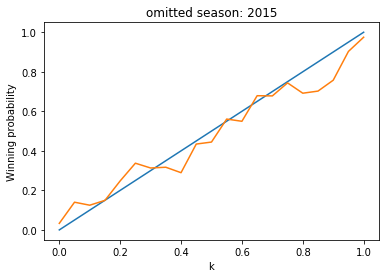

2016
mse: 0.002249221839134311
brier: 0.0908669582544136


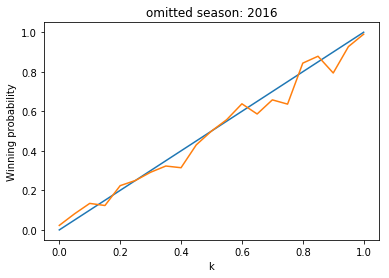

2017
mse: 0.006090495100890081
brier: 0.09219719708829702


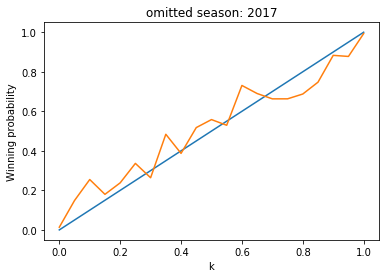

2018
mse: 0.010286242347448345
brier: 0.09915892964324258


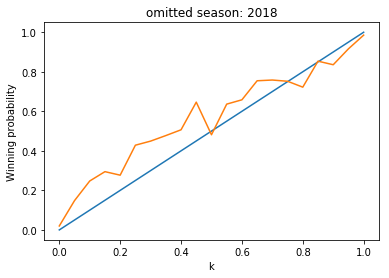

simplified model

average mse: 0.0037245080328611583
average brier score: 0.09210608074852344

2009
mse: 0.0032521142274509296
brier: 0.09065534812665112


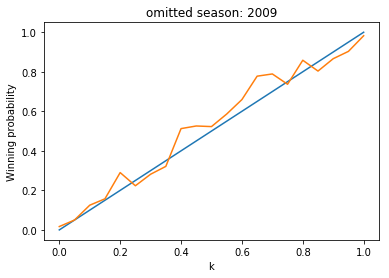

2010
mse: 0.0025861618245484317
brier: 0.0927717113529845


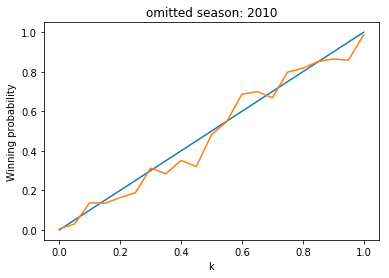

2011
mse: 0.0027709679211592405
brier: 0.0940110830837616


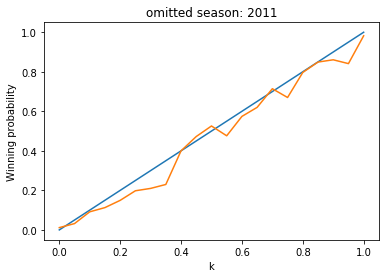

2012
mse: 0.006219676591318148
brier: 0.09751841580327564


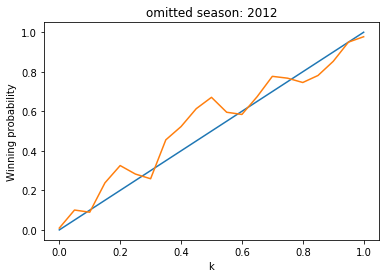

2013
mse: 0.004487284023953395
brier: 0.09892568688970171


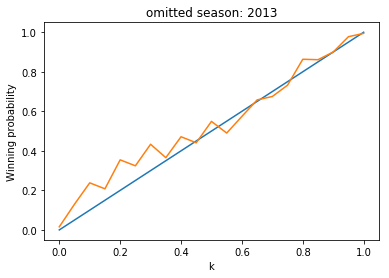

2014
mse: 0.0027365783818026532
brier: 0.07677412558221487


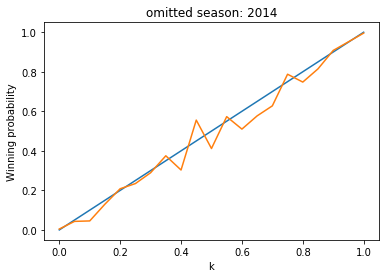

2015
mse: 0.003982412250226687
brier: 0.10136219732858322


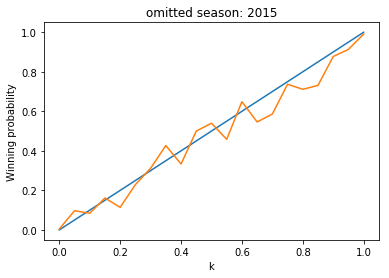

2016
mse: 0.0024235682679162335
brier: 0.09110100212516048


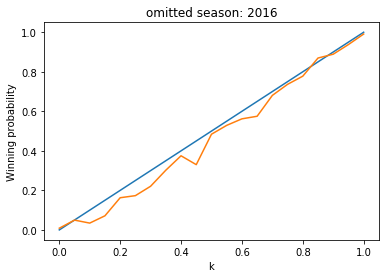

2017
mse: 0.003912705892627635
brier: 0.0820131957057876


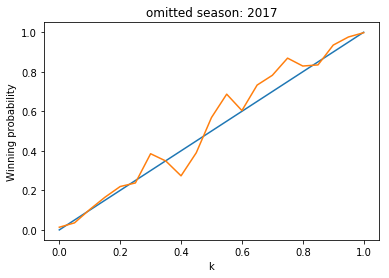

2018
mse: 0.004873610947608227
brier: 0.09592804148711379


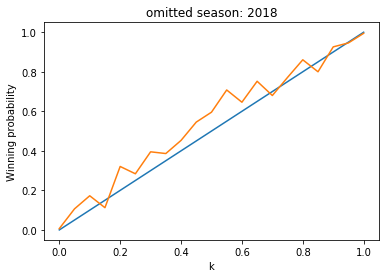

In [22]:
print("full model\n")
check_accuracy_lock_nettleton_wrapper2(test_x, test_y, results1, 5, 0, "full")

print("simplified model\n")
check_accuracy_lock_nettleton_wrapper2(test_x2, test_y, results2, 5, 0, "simplified")